# Summary Statistics on Similarity Measure

In [2]:
import pandas as pd
import os
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

In [3]:
signal_path = 'G:\\ResearchCenter\\MA-ML\\TextSignals\\'
os.listdir(signal_path)

['Count-Cosine_Disclosures.csv',
 'Count-Cosine_LegalProceedings.csv',
 'Count-Cosine_MDA.csv',
 'Count-Cosine_RiskFactors.csv',
 'tfidf-Cosine_Disclosures.csv',
 'tfidf-Cosine_LegalProceedings.csv',
 'tfidf-Cosine_MDA.csv',
 'tfidf-Cosine_Risk Factors.csv']

In [13]:
file_list = ['tfidf-Cosine_Disclosures.csv','tfidf-Cosine_LegalProceedings.csv','tfidf-Cosine_MDA.csv','tfidf-Cosine_Risk Factors.csv']
signal_dict = {}
for file in file_list:
    signal_df = pd.read_csv(signal_path+file,index_col = [0]).unstack().replace(0,np.nan).dropna()
    signal_name = file.split('.')[0].split('_')[-1]
    signal_dict[signal_name] = signal_df

## stats

In [16]:
stats_df = pd.DataFrame()
for k,v in signal_dict.items():
    stats_df[k]= v.describe()
stats_df.T

,count,mean,std,min,25%,50%,75%,max
Disclosures,31271.0,0.305744,0.317239,1.110223e-16,0.049037,0.133793,0.585493,0.985650
LegalProceedings,28097.0,0.366020,0.323662,1.110223e-16,0.061444,0.276303,0.650597,0.993820
MDA,39331.0,0.238414,0.264270,1.110223e-16,0.086877,0.142388,0.232060,0.997000
Risk Factors,18618.0,0.497127,0.390023,1.110223e-16,0.032411,0.625192,0.883234,0.987688


In [17]:
stats_df.to_csv('TFIDF-Cosine-Stats.csv')

## Section Correlation

In [21]:
corr_df = pd.DataFrame(columns = ['level_0','file_date'])
for k,v in signal_dict.items():
    corr_df = pd.merge(corr_df,v.rename(k).reset_index(),on = ['level_0','file_date'],how = 'outer')
corr_df.dropna().drop(columns = ['level_0','file_date']).corr()

,Disclosures,LegalProceedings,MDA,Risk Factors
Disclosures,1.000000,0.184775,0.269813,0.276651
LegalProceedings,0.184775,1.000000,0.113448,0.149856
MDA,0.269813,0.113448,1.000000,0.120708
Risk Factors,0.276651,0.149856,0.120708,1.000000


In [22]:
corr_df.dropna().drop(columns = ['level_0','file_date']).corr().to_csv('TFIDF-Cosine-Corr.csv')

# Fama-Macbeth Regression

## Construct Panel Data Set

In [34]:
ccm_df = pd.read_csv('G:\\ResearchCenter\\MA-ML\\WRDS\\CCM-Monthly.csv',usecols=['GVKEY','LIID','LINKPRIM','LPERMNO','datadate','cik'])
ccm_df.head()

,GVKEY,LINKPRIM,LIID,LPERMNO,datadate,cik
0,1000,P,1,25881,19720131,NaN
1,1000,P,1,25881,19720930,NaN
2,1000,P,1,25881,19751130,NaN
3,1000,P,1,25881,19720430,NaN
4,1000,P,1,25881,19780331,NaN


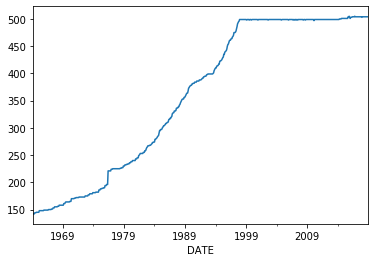

In [35]:
import re
ccm_df = ccm_df.sort_values(['GVKEY','LIID'])
ccm_df['DATE'] = pd.to_datetime(ccm_df['datadate'],format='%Y%m%d')
sp_df = pd.read_csv('G:\\ResearchCenter\\MA-ML\\WRDS\\SP500.csv')
sp_df = sp_df.rename(columns = {'gvkey':'GVKEY'})
sp_df['LIID'] = sp_df['iid'].astype(str).apply(lambda x:re.sub('[^0-9]','', x)).astype(int)
sp_df = sp_df[sp_df['conm'] == 'S&P 500 Comp-Ltd']
sp_df = sp_df[['GVKEY','LIID','from','thru','conm']].sort_values(['GVKEY','LIID'])
sp_df['from'] = pd.to_datetime(sp_df['from'],format='%Y%m%d')
sp_df['thru'] = pd.to_datetime(sp_df['thru'].fillna(20191231).astype(int).astype(str),format='%Y%m%d')
sp_universe = pd.merge(ccm_df,sp_df,on = ['GVKEY','LIID'],how = 'left')
sp_universe = sp_universe[~sp_universe['from'].isnull()]
sp_universe['SP'] = (sp_universe['DATE']>=sp_universe['from']) & (sp_universe['DATE']<=sp_universe['thru'])
sp_universe = sp_universe[sp_universe.SP == True]
sp_universe.groupby('DATE')['LPERMNO'].count().plot()
sp_universe = sp_universe.rename(columns = {'LPERMNO':'PERMNO'})

In [37]:
sp_universe = sp_universe.sort_values(['PERMNO','DATE'])
sp_universe.head()

,GVKEY,LINKPRIM,LIID,PERMNO,datadate,cik,DATE,from,thru,conm,SP
1757339,12136,P,1,10078,19920831,709519.0,1992-08-31,1992-08-01,2010-01-28,S&P 500 Comp-Ltd,True
1757356,12136,P,1,10078,19920930,709519.0,1992-09-30,1992-08-01,2010-01-28,S&P 500 Comp-Ltd,True
1757358,12136,P,1,10078,19921031,709519.0,1992-10-31,1992-08-01,2010-01-28,S&P 500 Comp-Ltd,True
1757333,12136,P,1,10078,19921130,709519.0,1992-11-30,1992-08-01,2010-01-28,S&P 500 Comp-Ltd,True
1757341,12136,P,1,10078,19921231,709519.0,1992-12-31,1992-08-01,2010-01-28,S&P 500 Comp-Ltd,True


In [38]:
Firm_df = pd.read_csv('G:\\ResearchCenter\\MA-ML\\WRDS\\Gu-Datashare.csv')
Firm_df.head()

,permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,10006,19570329,86308.500,1.117907,1.249717,0.134574,10.296745,0.024863,0.05954,0.002016,...,NaN,NaN,0.013856,1.557681e-07,0.029167,0.013546,0.914592,0.802461,1.066005e-07,37.0
1,10014,19570329,3903.375,0.331304,0.109762,0.006667,7.032404,0.065248,0.05954,-0.086957,...,NaN,NaN,0.031389,8.383815e-06,0.071429,0.031165,0.943409,0.716406,1.105263e+00,NaN
2,10022,19570329,9841.000,0.942052,0.887461,0.058761,7.294038,0.029338,0.05954,-0.037037,...,NaN,NaN,0.010066,5.360386e-06,0.020000,0.016886,0.993558,0.534808,2.387797e-07,NaN
3,10030,19570329,51901.000,0.886532,0.785940,-0.032065,9.516942,0.022007,0.05954,0.000000,...,NaN,NaN,0.009523,1.090908e-07,0.017857,0.009104,0.736000,0.712647,9.202902e-08,NaN
4,10057,19570329,35250.000,1.229520,1.511719,-0.102811,8.421013,0.025453,0.05954,-0.030717,...,NaN,NaN,0.007661,2.386914e-07,0.007194,0.006748,0.889503,0.775954,6.631579e+00,NaN


In [39]:
Firm_df['DATE'] = pd.to_datetime(Firm_df['DATE'],format='%Y%m%d')
Firm_df = Firm_df[Firm_df.DATE>=pd.to_datetime('1990-01-01')]
Firm_df = Firm_df.rename(columns = {'permno':'PERMNO'})

In [41]:
from pandas.tseries.offsets import MonthEnd
ret_df = pd.read_csv('G:\\ResearchCenter\\MA-ML\\WRDS\\CRSP-Monthly.csv',usecols = ['PERMNO','date','RET'],parse_dates=['date']).\
rename(columns = {'date':'DATE'})
ret_df['RET'] = ret_df['RET'].replace('C',0).replace('B',0).astype(float)

Gu_df = pd.merge(Firm_df,ret_df,on = ['PERMNO','DATE'],how = 'inner')
Gu_df['DATE'] = Gu_df['DATE'] + MonthEnd(0)
Gu_df.head()

F:\ProgramFiles\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,PERMNO,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,RET
0,10001,1990-01-31,10347.750,0.021662,0.000469,0.348191,8.308600,0.037859,0.176861,0.037975,...,NaN,0.011227,1.775139e-06,0.037975,0.016407,0.986860,0.949456,1.250567e-07,49.0,-0.018519
1,10002,1990-01-31,7196.875,0.481374,0.231721,-0.268657,6.680698,0.018793,0.052835,-0.039216,...,NaN,0.076591,8.892446e-08,0.000000,0.008769,1.054909,3.257916,5.250000e+00,60.0,0.020408
2,10003,1990-01-31,18649.000,0.765371,0.585793,-0.281724,9.927839,0.040525,0.052835,-0.260870,...,NaN,0.052340,5.038062e-07,0.060606,0.032901,1.095062,7.855561,1.130387e-08,60.0,-0.088235
3,10005,1990-01-31,523.500,0.980056,0.960509,-0.033333,-0.287682,0.148197,0.348499,0.000000,...,NaN,0.666667,0.000000e+00,0.000000,0.000000,1.596570,0.225578,1.785000e+01,13.0,0.000000
4,10007,1990-01-31,28196.250,1.672263,2.796464,1.161458,11.458924,0.188609,0.165707,0.450331,...,7.0,0.018523,6.973217e-08,0.096257,0.034203,0.680109,11.343609,6.593119e-09,73.0,-0.474886


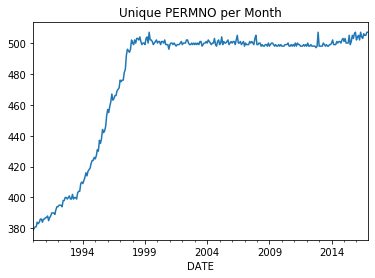

In [42]:
Gu_df = pd.merge(Gu_df,sp_universe[['PERMNO','DATE','SP']],on = ['PERMNO','DATE'],how = 'inner')
Gu_df = Gu_df[Gu_df['SP'] == True]
Gu_df.groupby('DATE')['PERMNO'].count().plot(title = 'Unique PERMNO per Month')
Gu_df = Gu_df.rename(columns = {'PERMNO':'permno'})
plt.show()

## Load Similarity Signals

In [49]:
CIK_mapping = pd.read_csv('G:\\ResearchCenter\\MA-ML\\WRDS\\MonthlyConstituent.csv')
CIK_mapping['DATE'] = pd.to_datetime(CIK_mapping['DATE'],format='%Y%m%d')+MonthEnd(0)
CIK_mapping.head()

,permno,DATE,cik,tic,permco
0,10006,1957-03-31,910627.0,4165A,22156
1,10102,1957-03-31,3010.0,AN.1,22164
2,10137,1957-03-31,3673.0,AYE,20045
3,10153,1957-03-31,3982.0,ALY,22169
4,10161,1957-03-31,4363.0,AMX.2,20063


In [154]:
signal_path = 'G:\\ResearchCenter\\MA-ML\\TextSignals\\'
os.listdir(signal_path)

['Count-Cosine_Disclosures.csv',
 'Count-Cosine_LegalProceedings.csv',
 'Count-Cosine_MDA.csv',
 'Count-Cosine_RiskFactors.csv',
 'tfidf-Cosine_Disclosures.csv',
 'tfidf-Cosine_LegalProceedings.csv',
 'tfidf-Cosine_MDA.csv',
 'tfidf-Cosine_RiskFactors.csv',
 'tfidf-Euclidian_Disclosures.csv',
 'tfidf-Euclidian_LegalProceedings.csv',
 'tfidf-Euclidian_MDA.csv',
 'tfidf-Euclidian_RiskFactors.csv',
 'WE-cosine_Disclosures.csv',
 'WE-cosine_LegalProceedings.csv',
 'WE-cosine_MDA.csv',
 'WE-cosine_RiskFactors.csv']

In [200]:
SignalFiles = ['tfidf-Cosine_Disclosures.csv','tfidf-Cosine_LegalProceedings.csv','tfidf-Cosine_MDA.csv','tfidf-Cosine_RiskFactors.csv']
SignalFiles = ['WE-cosine_Disclosures.csv','WE-cosine_LegalProceedings.csv','WE-cosine_MDA.csv','WE-cosine_RiskFactors.csv']
SignalFiles = ['tfidf-Euclidian_Disclosures.csv','tfidf-Euclidian_LegalProceedings.csv','tfidf-Euclidian_MDA.csv','tfidf-Euclidian_RiskFactors.csv']

In [201]:
Signals_df = pd.DataFrame(columns = ['level_0','file_date'])
for file in SignalFiles:
    signal_df = pd.read_csv(signal_path+file,index_col = [0]).sort_index().replace(0,np.nan).ffill()
    signal_df = signal_df.unstack()
    signal_name = file.split('.')[0].split('_')[-1]
    Signals_df = pd.merge(Signals_df,signal_df.rename(signal_name).reset_index(),on = ['level_0','file_date'],how = 'outer')
Signals_df = Signals_df.rename(columns = {'level_0':'cik'})
Signals_df['DATE'] = pd.to_datetime(Signals_df['file_date'])+MonthEnd(0)
Signals_df.head()

,cik,file_date,Disclosures,LegalProceedings,MDA,RiskFactors,DATE
0,1800,1996-01-31,NaN,NaN,NaN,NaN,1996-01-31
1,1800,1996-02-29,NaN,NaN,NaN,NaN,1996-02-29
2,1800,1996-03-31,NaN,0.722701,NaN,NaN,1996-03-31
3,1800,1996-04-30,NaN,0.722701,NaN,NaN,1996-04-30
4,1800,1996-05-31,NaN,0.889033,NaN,NaN,1996-05-31


In [202]:
Signals_df['cik'] = Signals_df['cik'].astype(float)
Similarity_df = pd.merge(Signals_df,CIK_mapping,on = ['cik','DATE'],how = 'inner')
Similarity_df.head()

,cik,file_date,Disclosures,LegalProceedings,MDA,RiskFactors,DATE,permno,tic,permco
0,1800.0,1996-01-31,NaN,NaN,NaN,NaN,1996-01-31,20482,ABT,20017
1,1800.0,1996-02-29,NaN,NaN,NaN,NaN,1996-02-29,20482,ABT,20017
2,1800.0,1996-03-31,NaN,0.722701,NaN,NaN,1996-03-31,20482,ABT,20017
3,1800.0,1996-04-30,NaN,0.722701,NaN,NaN,1996-04-30,20482,ABT,20017
4,1800.0,1996-05-31,NaN,0.889033,NaN,NaN,1996-05-31,20482,ABT,20017


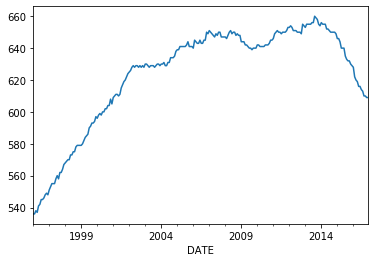

In [203]:
Similarity_df.groupby('DATE')['permco'].count().plot()

In [204]:
Similarity_df['DATE'] = Similarity_df['DATE'] + MonthEnd(1)

## S&P500 Panel Dataset

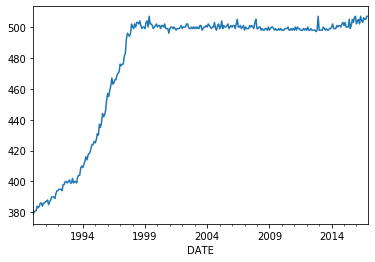

In [205]:
signal_drop_cols = ['cik','file_date','tic','permco']
PanelDataSet = pd.merge(Similarity_df.drop(signal_drop_cols,axis=1),Gu_df,how = 'right',on = ['permno','DATE'])
PanelDataSet.groupby('DATE')['permno'].count().plot()

## Regression Models
1.Similarity only

2.Size(mvel1) + logBM(log bm) + Reversal(mom1m) + Momentum(mom12m) + Beta(beta) 

3.Average Similarity + 2

In [206]:
signal_list = ['Disclosures', 'LegalProceedings', 'MDA', 'RiskFactors']
basic_x_list = ['mvel1','bm','mom1m','mom12m','beta']
basic_y = 'RET'

RegData = PanelDataSet.set_index(['permno','DATE'])[signal_list+basic_x_list+[basic_y]]
RegData.head()

Disclosures  LegalProceedings  MDA  RiskFactors  \
permno DATE                                                          
20482  1996-02-29          NaN               NaN  NaN          NaN   
       1996-03-31          NaN               NaN  NaN          NaN   
       1996-04-30          NaN          0.722701  NaN          NaN   
       1996-05-31          NaN          0.722701  NaN          NaN   
       1996-06-30          NaN          0.889033  NaN          NaN   

                        mvel1        bm     mom1m    mom12m      beta  \
permno DATE                                                             
20482  1996-02-29  16178775.0  0.156053  0.026066  0.195447  0.510352   
       1996-03-31  15875575.0  0.156053 -0.017647  0.222289  0.342560   
       1996-04-30  16042947.0  0.156053 -0.023952  0.192322  0.387341   
       1996-05-31  16400660.0  0.156053  0.002822  0.051018  0.301526   
       1996-06-30  16723297.0  0.156053  0.061538  0.037515  0.286947   

                        RET  
permno DATE                  
20482  1996-02-29 -0.017647  
       1996-03-31 -0.023952  
       1996-04-30  0.002822  
       1996-05-31  0.061538  
       1996-06-30  0.008696

### FillNA by CS Median

In [207]:
RegData2 = RegData.reset_index()
RegData2 = RegData2[RegData2[['permno','DATE']].duplicated()==False]
RegData2['LogBM'] = RegData2['bm'].apply(lambda x:np.log(x))
RegData2 = RegData2[RegData2.DATE>=pd.to_datetime('2001-01-01')]
for x in signal_list+basic_x_list:
    RegData2[x] = RegData2[x].fillna(RegData2.groupby('DATE')[x].transform(lambda x:x.dropna().median()))
RegData2 = RegData2.dropna()
RegData2.head()

,permno,DATE,Disclosures,LegalProceedings,MDA,RiskFactors,mvel1,bm,mom1m,mom12m,beta,RET,LogBM
59,20482,2001-01-31,1.368544,1.398455,1.097496,1.343857,4.232510e+07,0.133481,-0.120318,0.544330,0.116064,-0.069935,-2.013798
60,20482,2001-02-28,1.368544,1.398455,1.097496,1.343857,4.249565e+07,0.133481,-0.069935,0.507103,0.102912,0.092064,-2.013798
61,20482,2001-03-31,0.421664,1.403106,1.356268,1.343857,3.932840e+07,0.133481,0.092064,0.383120,0.066282,-0.036742,-2.013798
62,20482,2001-04-30,0.421664,1.403106,1.356268,1.343857,4.087876e+07,0.133481,-0.036742,0.416555,0.051961,-0.012715,-2.013798
63,20482,2001-05-31,0.421664,1.403106,1.356268,1.343857,4.343718e+07,0.133481,-0.012715,0.242991,0.084885,0.120742,-2.013798


### Regression

In [208]:
RegData2 = RegData2.set_index(['permno','DATE'])
RegData2['Combined'] = RegData2[signal_list].mean(axis=1)
RegData2 = RegData2.drop('bm',axis=1)
RegData2.shape

(91787, 11)

In [209]:
RegData2.to_csv('FM-Data_TDIDF_l2.csv')

# Backtesting

## Pure Factor Mimicking Portfolio

In [210]:
FMP_df = RegData2.reset_index()
FMP_df.columns

Index(['permno', 'DATE', 'Disclosures', 'LegalProceedings', 'MDA',
       'RiskFactors', 'mvel1', 'mom1m', 'mom12m', 'beta', 'RET', 'LogBM',
       'Combined'],
      dtype='object')

In [211]:
FMP_df['LogBM'] = FMP_df['LogBM'].replace(-np.inf,np.nan)
FMP_df['LogSize'] = FMP_df['mvel1'].apply(lambda x:np.log(x)).replace(-np.inf,np.nan)
FMP_df = FMP_df.dropna()

In [212]:
basic_x_list = ['LogSize', 'LogBM', 'mom1m', 'mom12m', 'beta']

In [213]:
FMP_df[basic_x_list].describe()

,LogSize,LogBM,mom1m,mom12m,beta
count,91775.000000,91775.000000,91775.000000,91775.000000,91775.000000
mean,16.275320,-0.966958,0.008989,0.103414,0.968281
std,0.992544,0.811985,0.098530,0.349312,0.529648
min,12.127655,-6.640842,-0.696000,-0.970490,-0.146804
25%,15.592416,-1.443752,-0.038252,-0.084949,0.601402
50%,16.243007,-0.911243,0.010101,0.092455,0.893338
75%,16.984862,-0.405872,0.056303,0.267450,1.255974
max,18.620470,2.012805,1.469375,7.800001,3.731393


In [214]:
MonthList = sorted(list(FMP_df['DATE'].unique()))

fmp_rtn_df = pd.DataFrame()

for signal in ['Disclosures', 'LegalProceedings', 'MDA', 'RiskFactors','Combined']:
    signal_rtn_s = list()
    for month in MonthList:
        print(signal,month)
        tmp = FMP_df[FMP_df.DATE == month].drop(columns = ['permno'])
        m = sm.OLS(tmp.RET,tmp[basic_x_list+[signal]]).fit()
        #m = sm.OLS(tmp.RET,sm.add_constant(tmp[basic_x_list+[signal]])).fit()
        signal_rtn = m.params[-1]
        signal_rtn_s.append(signal_rtn)

    signal_rtn_s = pd.Series(signal_rtn_s,index = MonthList)
    fmp_rtn_df[signal] = signal_rtn_s

Disclosures 2001-01-31T00:00:00.000000000
Disclosures 2001-02-28T00:00:00.000000000
Disclosures 2001-03-31T00:00:00.000000000
Disclosures 2001-04-30T00:00:00.000000000
Disclosures 2001-05-31T00:00:00.000000000
Disclosures 2001-06-30T00:00:00.000000000
Disclosures 2001-07-31T00:00:00.000000000
Disclosures 2001-08-31T00:00:00.000000000
Disclosures 2001-09-30T00:00:00.000000000
Disclosures 2001-10-31T00:00:00.000000000
Disclosures 2001-11-30T00:00:00.000000000
Disclosures 2001-12-31T00:00:00.000000000
Disclosures 2002-01-31T00:00:00.000000000
Disclosures 2002-02-28T00:00:00.000000000
Disclosures 2002-03-31T00:00:00.000000000
Disclosures 2002-04-30T00:00:00.000000000
Disclosures 2002-05-31T00:00:00.000000000
Disclosures 2002-06-30T00:00:00.000000000
Disclosures 2002-07-31T00:00:00.000000000
Disclosures 2002-08-31T00:00:00.000000000
Disclosures 2002-09-30T00:00:00.000000000
Disclosures 2002-10-31T00:00:00.000000000
Disclosures 2002-11-30T00:00:00.000000000
Disclosures 2002-12-31T00:00:00.00

LegalProceedings 2004-05-31T00:00:00.000000000
LegalProceedings 2004-06-30T00:00:00.000000000
LegalProceedings 2004-07-31T00:00:00.000000000
LegalProceedings 2004-08-31T00:00:00.000000000
LegalProceedings 2004-09-30T00:00:00.000000000
LegalProceedings 2004-10-31T00:00:00.000000000
LegalProceedings 2004-11-30T00:00:00.000000000
LegalProceedings 2004-12-31T00:00:00.000000000
LegalProceedings 2005-01-31T00:00:00.000000000
LegalProceedings 2005-02-28T00:00:00.000000000
LegalProceedings 2005-03-31T00:00:00.000000000
LegalProceedings 2005-04-30T00:00:00.000000000
LegalProceedings 2005-05-31T00:00:00.000000000
LegalProceedings 2005-06-30T00:00:00.000000000
LegalProceedings 2005-07-31T00:00:00.000000000
LegalProceedings 2005-08-31T00:00:00.000000000
LegalProceedings 2005-09-30T00:00:00.000000000
LegalProceedings 2005-10-31T00:00:00.000000000
LegalProceedings 2005-11-30T00:00:00.000000000
LegalProceedings 2005-12-31T00:00:00.000000000
LegalProceedings 2006-01-31T00:00:00.000000000
LegalProceedi

MDA 2003-10-31T00:00:00.000000000
MDA 2003-11-30T00:00:00.000000000
MDA 2003-12-31T00:00:00.000000000
MDA 2004-01-31T00:00:00.000000000
MDA 2004-02-29T00:00:00.000000000
MDA 2004-03-31T00:00:00.000000000
MDA 2004-04-30T00:00:00.000000000
MDA 2004-05-31T00:00:00.000000000
MDA 2004-06-30T00:00:00.000000000
MDA 2004-07-31T00:00:00.000000000
MDA 2004-08-31T00:00:00.000000000
MDA 2004-09-30T00:00:00.000000000
MDA 2004-10-31T00:00:00.000000000
MDA 2004-11-30T00:00:00.000000000
MDA 2004-12-31T00:00:00.000000000
MDA 2005-01-31T00:00:00.000000000
MDA 2005-02-28T00:00:00.000000000
MDA 2005-03-31T00:00:00.000000000
MDA 2005-04-30T00:00:00.000000000
MDA 2005-05-31T00:00:00.000000000
MDA 2005-06-30T00:00:00.000000000
MDA 2005-07-31T00:00:00.000000000
MDA 2005-08-31T00:00:00.000000000
MDA 2005-09-30T00:00:00.000000000
MDA 2005-10-31T00:00:00.000000000
MDA 2005-11-30T00:00:00.000000000
MDA 2005-12-31T00:00:00.000000000
MDA 2006-01-31T00:00:00.000000000
MDA 2006-02-28T00:00:00.000000000
MDA 2006-03-31

RiskFactors 2006-11-30T00:00:00.000000000
RiskFactors 2006-12-31T00:00:00.000000000
RiskFactors 2007-01-31T00:00:00.000000000
RiskFactors 2007-02-28T00:00:00.000000000
RiskFactors 2007-03-31T00:00:00.000000000
RiskFactors 2007-04-30T00:00:00.000000000
RiskFactors 2007-05-31T00:00:00.000000000
RiskFactors 2007-06-30T00:00:00.000000000
RiskFactors 2007-07-31T00:00:00.000000000
RiskFactors 2007-08-31T00:00:00.000000000
RiskFactors 2007-09-30T00:00:00.000000000
RiskFactors 2007-10-31T00:00:00.000000000
RiskFactors 2007-11-30T00:00:00.000000000
RiskFactors 2007-12-31T00:00:00.000000000
RiskFactors 2008-01-31T00:00:00.000000000
RiskFactors 2008-02-29T00:00:00.000000000
RiskFactors 2008-03-31T00:00:00.000000000
RiskFactors 2008-04-30T00:00:00.000000000
RiskFactors 2008-05-31T00:00:00.000000000
RiskFactors 2008-06-30T00:00:00.000000000
RiskFactors 2008-07-31T00:00:00.000000000
RiskFactors 2008-08-31T00:00:00.000000000
RiskFactors 2008-09-30T00:00:00.000000000
RiskFactors 2008-10-31T00:00:00.00

Combined 2010-04-30T00:00:00.000000000
Combined 2010-05-31T00:00:00.000000000
Combined 2010-06-30T00:00:00.000000000
Combined 2010-07-31T00:00:00.000000000
Combined 2010-08-31T00:00:00.000000000
Combined 2010-09-30T00:00:00.000000000
Combined 2010-10-31T00:00:00.000000000
Combined 2010-11-30T00:00:00.000000000
Combined 2010-12-31T00:00:00.000000000
Combined 2011-01-31T00:00:00.000000000
Combined 2011-02-28T00:00:00.000000000
Combined 2011-03-31T00:00:00.000000000
Combined 2011-04-30T00:00:00.000000000
Combined 2011-05-31T00:00:00.000000000
Combined 2011-06-30T00:00:00.000000000
Combined 2011-07-31T00:00:00.000000000
Combined 2011-08-31T00:00:00.000000000
Combined 2011-09-30T00:00:00.000000000
Combined 2011-10-31T00:00:00.000000000
Combined 2011-11-30T00:00:00.000000000
Combined 2011-12-31T00:00:00.000000000
Combined 2012-01-31T00:00:00.000000000
Combined 2012-02-29T00:00:00.000000000
Combined 2012-03-31T00:00:00.000000000
Combined 2012-04-30T00:00:00.000000000
Combined 2012-05-31T00:00

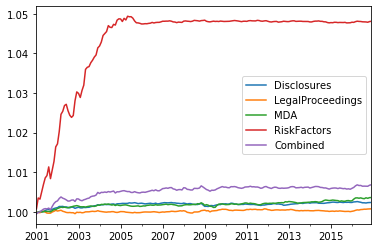

In [218]:
nav_df = (fmp_rtn_df/100+1).cumprod()
nav_df.plot()
nav_df.to_csv('PFMP-TFIDF-L2.csv')

In [116]:
def max_drawdown(returns):
    """calculate maximum drawdown
    :param returns--pd.Series, index=datetime object"""
    cr = returns.add(1).cumprod()
    dd = cr.div(cr.cummax()).sub(1)
    mdd = dd.min()
    return abs(mdd)

In [219]:
mdd = fmp_rtn_df.apply(max_drawdown)

In [121]:
def cum_mean_returns(returns,freq = 12):
    """calculate cumulative returns
    :param returns--pd.Series, index=datetime object
    :return: geometric mean of returns"""
    cr = returns.add(1).product()
    ret = cr**(freq/len(returns))-1
    return ret

In [220]:
rtn = fmp_rtn_df.apply(cum_mean_returns)

In [221]:
vol = fmp_rtn_df.apply(lambda x:np.nanstd(x)*np.sqrt(12))

In [222]:
sr = rtn/vol

In [223]:
cr = rtn/mdd

In [224]:
pr_df = pd.DataFrame({'rtn':rtn,'vol':vol,'Sharpe':sr,'Calmar':cr})
pr_df.to_csv('PFMP-TFIDF-L2_stats.csv')

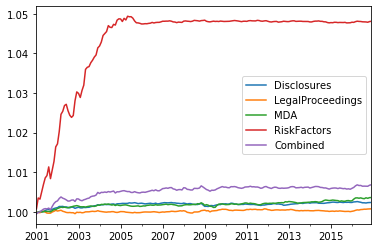

In [225]:
nav_df.plot()

## L/S EW/CW

In [226]:
LS_df = RegData2.drop(basic_x_list[1:],axis=1).copy().reset_index()
LS_df.head()

,permno,DATE,Disclosures,LegalProceedings,MDA,RiskFactors,mvel1,RET,Combined
0,20482,2001-01-31,1.368544,1.398455,1.097496,1.343857,4.232510e+07,-0.069935,1.302088
1,20482,2001-02-28,1.368544,1.398455,1.097496,1.343857,4.249565e+07,0.092064,1.302088
2,20482,2001-03-31,0.421664,1.403106,1.356268,1.343857,3.932840e+07,-0.036742,1.131224
3,20482,2001-04-30,0.421664,1.403106,1.356268,1.343857,4.087876e+07,-0.012715,1.131224
4,20482,2001-05-31,0.421664,1.403106,1.356268,1.343857,4.343718e+07,0.120742,1.131224


In [227]:
def assign_dir(x,tq,bq):
    if x>=tq:
        return 1
    elif x<=bq:
        return -1
    else:
        return 0

In [228]:
q = 0.1
MonthList = sorted(list(LS_df['DATE'].unique()))

ew_rtn_df = pd.DataFrame()

for signal in ['Disclosures', 'LegalProceedings', 'MDA', 'RiskFactors','Combined']:
    signal_rtn_s = list()
    print(signal)
    for month in MonthList:
        #print(signal,month)
        tmp = LS_df[LS_df.DATE == month]
        top_q = tmp[signal].quantile(1-q)
        bottom_q = tmp[signal].quantile(q)
        tmp['pos'] = tmp[signal].apply(lambda x:assign_dir(x,top_q,bottom_q))
        tmp = tmp[tmp['pos']!=0]
        tmp['pos'] = tmp['pos']/tmp.shape[0]
        signal_rtn = (tmp['pos']*tmp['RET']).sum()
        signal_rtn_s.append(signal_rtn)

    signal_rtn_s = pd.Series(signal_rtn_s,index = MonthList)
    ew_rtn_df[signal] = signal_rtn_s

Disclosures


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


LegalProceedings
MDA
RiskFactors
Combined


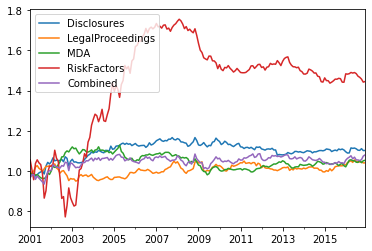

In [229]:
(ew_rtn_df+1).cumprod().plot()

In [230]:
nav_df = (ew_rtn_df+1).cumprod()
nav_df.to_csv('EW-TFIDF-L2.csv')

In [231]:
q = 0.1
MonthList = sorted(list(LS_df['DATE'].unique()))

cw_rtn_df = pd.DataFrame()

for signal in ['Disclosures', 'LegalProceedings', 'MDA', 'RiskFactors','Combined']:
    signal_rtn_s = list()
    print(signal)
    for month in MonthList:
        #print(signal,month)
        tmp = LS_df[LS_df.DATE == month]
        top_q = tmp[signal].quantile(1-q)
        bottom_q = tmp[signal].quantile(q)
        tmp['pos'] = tmp[signal].apply(lambda x:assign_dir(x,top_q,bottom_q))
        tmp = tmp[tmp['pos']!=0]
        tmp['cw'] = tmp.groupby('pos')['mvel1'].transform(lambda x:x.sum())
        tmp['cw'] = 0.5*tmp['mvel1']*tmp['pos']/tmp['cw']
        signal_rtn = (tmp['cw']*tmp['RET']).sum()
        signal_rtn_s.append(signal_rtn)

    signal_rtn_s = pd.Series(signal_rtn_s,index = MonthList)
    cw_rtn_df[signal] = signal_rtn_s

Disclosures


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

LegalProceedings


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

MDA


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

RiskFactors


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

Combined


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [233]:
nav_df = (cw_rtn_df+1).cumprod()
nav_df.to_csv('CW-TFIDF-L2.csv')

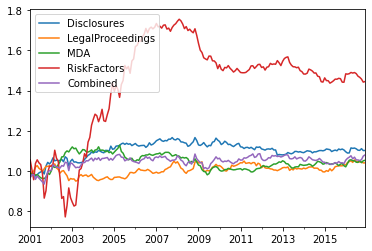

In [232]:
nav_df.plot()

In [234]:
q = 0.1
MonthList = sorted(list(LS_df['DATE'].unique()))

aw_rtn_df = pd.DataFrame()

for signal in ['Disclosures', 'LegalProceedings', 'MDA', 'RiskFactors','Combined']:
    signal_rtn_s = list()
    print(signal)
    for month in MonthList:
        #print(signal,month)
        tmp = LS_df[LS_df.DATE == month]
        top_q = tmp[signal].quantile(1-q)
        bottom_q = tmp[signal].quantile(q)
        tmp['pos'] = tmp[signal].apply(lambda x:assign_dir(x,top_q,bottom_q))
        tmp = tmp[tmp['pos']!=0]
        tmp['aw'] = tmp.groupby('pos')[signal].transform(lambda x:x.sum())
        tmp['aw'] = 0.5*tmp[signal]*tmp['pos']/tmp['aw']
        signal_rtn = (tmp['aw']*tmp['RET']).sum()
        signal_rtn_s.append(signal_rtn)

    signal_rtn_s = pd.Series(signal_rtn_s,index = MonthList)
    aw_rtn_df[signal] = signal_rtn_s

Disclosures


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

LegalProceedings


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

MDA


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

RiskFactors


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

Combined


F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [235]:
nav_df = (aw_rtn_df+1).cumprod()
nav_df.to_csv('AW-TFIDF-L2.csv')

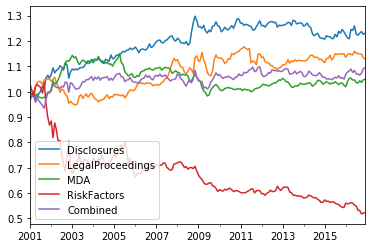

In [236]:
nav_df.plot()

# Correlation between different Similarity Score

In [237]:
signal_path = 'G:\\ResearchCenter\\MA-ML\\TextSignals\\'
os.listdir(signal_path)

['Count-Cosine_Disclosures.csv',
 'Count-Cosine_LegalProceedings.csv',
 'Count-Cosine_MDA.csv',
 'Count-Cosine_RiskFactors.csv',
 'tfidf-Cosine_Disclosures.csv',
 'tfidf-Cosine_LegalProceedings.csv',
 'tfidf-Cosine_MDA.csv',
 'tfidf-Cosine_RiskFactors.csv',
 'tfidf-Euclidian_Disclosures.csv',
 'tfidf-Euclidian_LegalProceedings.csv',
 'tfidf-Euclidian_MDA.csv',
 'tfidf-Euclidian_RiskFactors.csv',
 'WE-cosine_Disclosures.csv',
 'WE-cosine_LegalProceedings.csv',
 'WE-cosine_MDA.csv',
 'WE-cosine_RiskFactors.csv']

In [238]:
signal_dict = {}
for file in os.listdir(signal_path):
    signal_df = pd.read_csv(signal_path+file,index_col = [0]).unstack().replace(0,np.nan).dropna()
    signal_name = file.split('.')[0]
    signal_dict[signal_name] = signal_df

In [240]:
corr_df = pd.DataFrame(columns = ['level_0','file_date'])
for k,v in signal_dict.items():
    corr_df = pd.merge(corr_df,v.rename(k).reset_index(),on = ['level_0','file_date'],how = 'outer')
corr_map = corr_df.dropna().drop(columns = ['level_0','file_date']).corr()

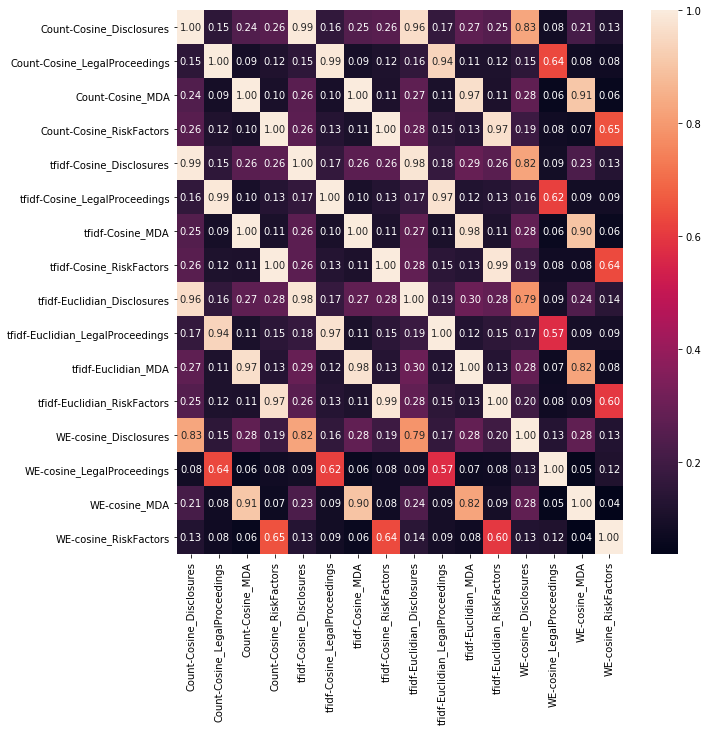

In [246]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(corr_map,annot=True,fmt=".2f")
plt.show()